In [1]:
import string
import joblib
from os import path

import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils import ls, cat
from pathlib import Path

from time import time


tqdm.pandas()

In [8]:
#Dmitry
# DATA_DIR = '../../data'
# OUTPUT_DIR = '../../data'

#Anton
DATA_DIR = Path('D:/data/lenta')
OUTPUT_DIR = Path('D:/data/lenta')

#Dmitry
# TRAIN_PATH = f'{DATA_DIR}/lenta-ru-news.csv'

#Anton
TRAIN_PATH = Path('D:/data/lenta/lenta-ru-news.csv/lenta-ru-news.csv')
NUM_ROWS = 5000

TRAIN_LEMMAS_PATH = OUTPUT_DIR / 'train_lemmas.csv'

ls(DATA_DIR)

DIR      D:\data\lenta\lenta-ru-news.csv
611.9 MB D:\data\lenta\lenta-ru-news.csv.zip
  7.8 MB D:\data\lenta\train_lemmas.csv


In [5]:
# df_train = pd.read_csv(TRAIN_PATH, nrows=NUM_ROWS)
df_train = pd.read_csv(TRAIN_PATH, nrows=NUM_ROWS)

display(df_train.head(3))
display(df_train.shape)

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17


(5000, 6)

## Features

In [46]:
text_cols = ['title', 'text']
all_colls = ['title', 'text', 'date']
text_cols, all_colls

(['title', 'text'], ['title', 'text', 'date'])

In [47]:
df_train[all_colls].head()

,title,text,date
0,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,1914/09/16
1,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",1914/09/16
2,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",1914/09/17
3,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,1914/09/17
4,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",1914/09/18


## Tokenized Text

In [48]:
# !pip install spacy
# python -m spacy download ru_core_news_md

In [49]:
import spacy

nlp = spacy.load('ru_core_news_md', disable=['tagger', 'attribute_ruler', 'senter', 'parser', 'ner'])

In [50]:
train_tokens = df_train[text_cols].fillna('') \
    .progress_applymap(nlp)
    
train_tokens

100%|██████████| 10000/10000 [03:44<00:00, 44.54it/s]


,title,text
0,"(1914, ., Русские, войска, вступили, в, , пре...","(Бои, у, Сопоцкина, и, Друскеник, закончились,..."
1,"(1914, ., Празднование, столетия, М.Ю., Лермон...","(Министерство, народного, просвещения, ,, в, в..."
2,"(1914, ., Das, ist, Nesteroff, !)","(Штабс, -, капитан, П., Н., Нестеров, на, днях..."
3,"(1914, ., Бульдог, -, гонец, под, Льежем)","(Фотограф, -, корреспондент, Daily, Mirror, ра..."
4,"(1914, ., Под, Люблином, пойман, швабский, зверь)","(Лица, ,, приехавшие, в, Варшаву, из, Люблина,..."
...,...,...
4995,"(Путин, наградил, выдающихся, российских, женщин)","(В, преддверии, Международного, женского, дня,..."
4996,"(Лига, чемпионов, :, "", Реал, "", жаждет, реванша)","(В, среду, в, Мюнхене, в, матче, Лиги, чемпион..."
4997,"(Засада, у, , станицы, Ассиновская, :, убиты,...","(Два, сотрудника, милиции, погибли, и, два, по..."
4998,"(Андрея, Бабицкого, не, , пускают, в, , Европу)","(Следователи, МВД, России, не, позволили, корр..."


In [51]:
def is_alphanum(token):
    return not token.is_punct \
        and not token.is_currency \
        and not token.is_digit \
        and not token.is_punct \
        and not token.is_oov \
        and not token.is_space \
        and not token.is_stop \
        and not token.like_num \
        and not token.pos_ == "PROPN"

df_text = train_tokens \
    .progress_applymap(lambda x: ' '.join(t.lemma_ for t in x if is_alphanum(t)))

df_output_train = pd.concat([df_text, df_train['date']], axis=1)

df_output_train.to_csv(TRAIN_LEMMAS_PATH)

100%|██████████| 10000/10000 [00:00<00:00, 10334.40it/s]


In [52]:
ls(OUTPUT_DIR, path.basename(TRAIN_LEMMAS_PATH))

  7.8 MB D:\data\lenta/train_lemmas.csv


In [43]:
df = pd.read_csv(TRAIN_LEMMAS_PATH, index_col=[0])
df['date'] = df['date'].astype('datetime64')
df

,title,text,date
0,войско вступить предел,закончиться отступление германец приблизиться ...,1914-09-16
1,столетие отложить,народный просвещение вид происходить чрезвычай...,1914-09-16
2,ist,капитан день увидеть район лететь расположение...,1914-09-17
3,гонец,корреспондент рассказывать случай порадует дру...,1914-09-17
4,поймать швабский зверь,приехать передавать доставить швабский зверь в...,1914-09-18
...,...,...,...
4995,наградить выдающийся российский женщина,преддверие женский день исполнять обязанность ...,2000-03-07
4996,чемпион жаждать реванш,среда матч чемпион принимать мадридский встреч...,2000-03-07
4997,станица убить милиционер,сотрудник милиция погибнуть получить ранение р...,2000-03-07
4998,пускать,позволить корреспондент радио поехать весенний...,2000-03-07


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_features = 1000

data_samples = df.title.fillna('')
data_samples

0                                  войско вступить предел
1                                       столетие отложить
2                                                     ist
3                                                   гонец
4                                  поймать швабский зверь
                              ...                        
4995              наградить выдающийся российский женщина
4996                               чемпион жаждать реванш
4997                             станица убить милиционер
4998                                              пускать
4999    опровергнуть информация захват боевик ряд чече...
Name: title, Length: 5000, dtype: object

In [11]:

# Use tf-idf features for NMF.
print("Extracting tf-idf features")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features)

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

Extracting tf-idf features
done in 0.035s.
Extracting tf features for
done in 0.027s.



In [12]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 7.532s.


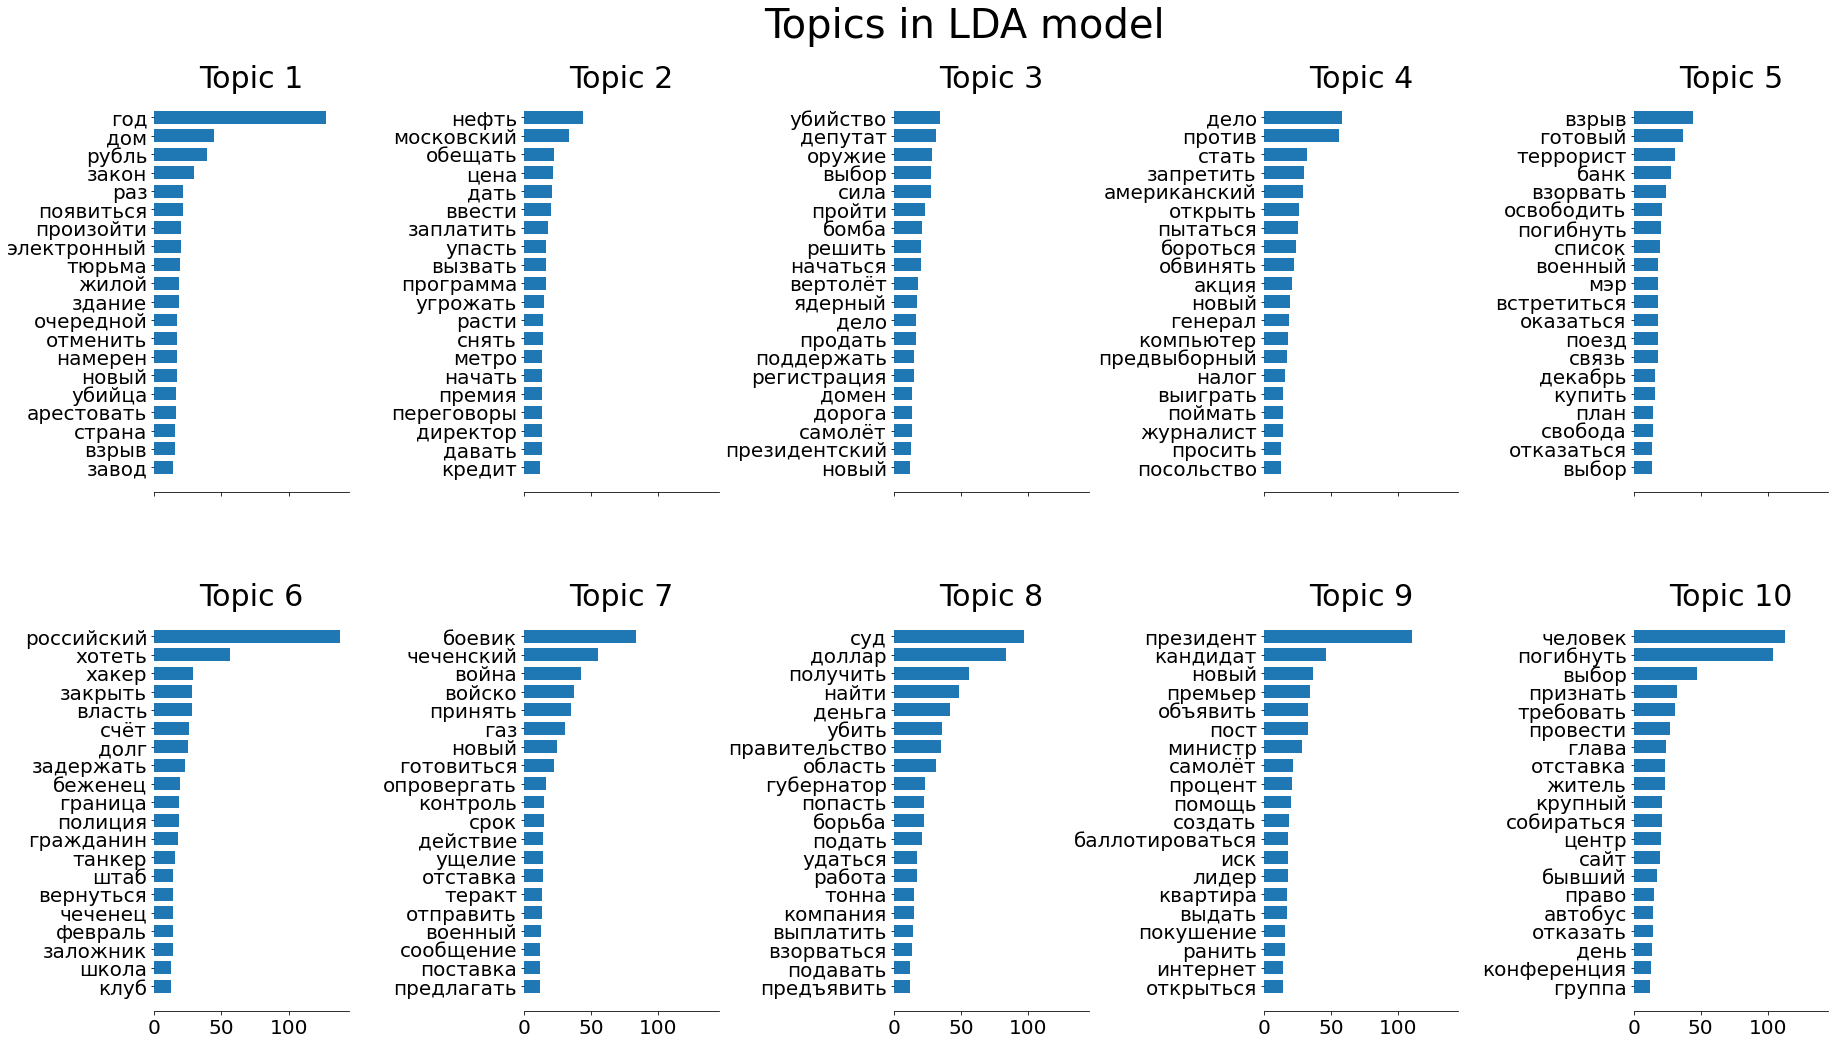

In [58]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)


print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)

t0 = time()
doc_topics = lda.fit_transform(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

<AxesSubplot:>

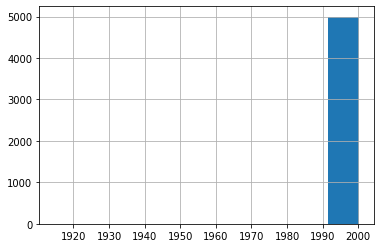

In [14]:
df.date.hist()

In [34]:
df_train = pd.read_csv(TRAIN_PATH)

C:\Users\anton\AppData\Local\Temp/ipykernel_2416/4027910153.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(TRAIN_PATH)


In [35]:
df_train

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
800970,https://lenta.ru/news/2019/12/14/shnur/,Шнуров раскритиковал Гагарину на «Голосе»,Певец Сергей Шнуров раскритиковал свою коллегу...,NaN,ТВ и радио,2019/12/14
800971,https://lenta.ru/news/2019/12/14/dolg/,В России предложили изменить правила взыскания...,Министерство юстиции России предложило изменит...,NaN,Все,2019/12/14
800972,https://lenta.ru/news/2019/12/14/dark_euro/,В России назвали «черную дату» для Европы,Испытание США ранее запрещенной Договором о ли...,NaN,Политика,2019/12/14
800973,https://lenta.ru/news/2019/12/14/meteo/,Россиянам пообещали аномально теплую погоду,В ближайшие дни в европейской части России пог...,NaN,Общество,2019/12/14


In [37]:
df_train['date'] = df["date"].astype("datetime64")

Рапределение дат в исходном dataset


<AxesSubplot:xlabel='date,date'>

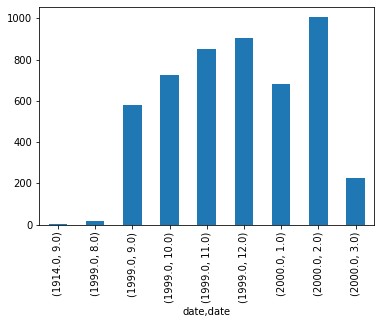

In [33]:
print('Рапределение дат в исходном dataset')
df_train.my.groupby([df["date"].dt.year, df["date"].dt.month]).count().plot(kind="bar")

In [50]:
print('Количество строк с датой в 1914 году:')
print(df_train[df_train.date < '1950-01-01'].date.count())

Количество строк с датой в 1914 году:
5


In [52]:
df.drop(df[df.date < '1950-01-01'].index, inplace=True)

In [80]:
from pydoc_data.topics import topics


df_topic0 = df[df.topic ==0].groupby(by='date').count()

In [83]:
df_topic0

,title,text,topic
date,,,
1999-08-31,3,3,3
1999-09-01,3,3,3
1999-09-02,1,1,1
1999-09-06,2,2,2
1999-09-07,4,5,5
...,...,...,...
2000-03-03,9,9,9
2000-03-04,1,1,1
2000-03-05,2,2,2


<AxesSubplot:title={'center':'topic 0'}, xlabel='date'>

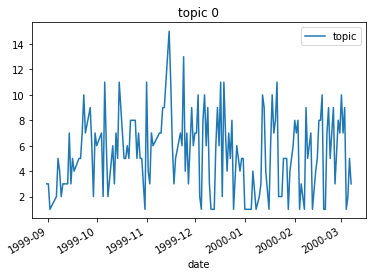

In [132]:
df_topic0.plot(y='topic',title='topic 0')

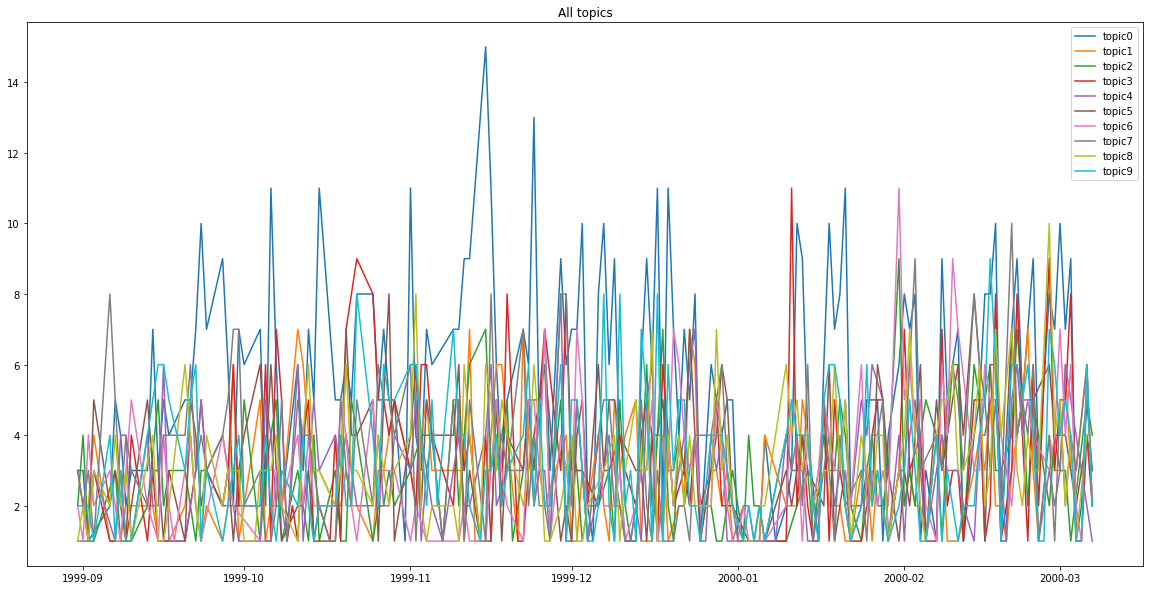

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

for i in range(0, 10):
    x = df[df.topic == i].groupby(by='date').count().index.to_numpy()
    y = df[df.topic == i].groupby(by='date').count().topic.to_numpy()
    plt.plot(x, y, label = 'topic' + str(i))


plt.legend()
plt.title('All topics')
plt.show()